## Final Project Submission

Please fill out:
* Student name: Leticia D Fernandes
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Abhineet
* Blog post URL:


In [1]:
import sqlite3
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
data = pd.read_csv('data/kc_house_data.csv')

In [3]:
import numpy as np
#data = data.drop(data[data.price>6000000])
data['yr_renovated'] = data.yr_renovated.fillna(0)
date_temp=pd.DataFrame({'yr_sold':pd.to_datetime(data.date).dt.year,'yr_renovated':data.yr_renovated,'yr_built':data.yr_built})
date_temp
data['inner_age']=np.where(date_temp.yr_renovated==0,(date_temp.yr_sold-date_temp.yr_built),(date_temp.yr_renovated-date_temp.yr_built))

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_square =data[['price','grade','sqft_living']]
df_square['grade_sq']=np.square(df_square.grade)
df_square['grade_log']=np.log(df_square.grade)
df_square['grade_exp']=np.exp(df_square.grade)
df_square['log_price']=np.log(df_square.price)
formula = 'log_price~grade'
model = ols(formula=formula, data=df_square).fit()
#model.summary()

In [5]:
data['waterfront']=data.waterfront.fillna(0)
data['view']=data.view.fillna(0)          

In [6]:
#sns.boxplot(x=df_square['grade'],y=df_square['log_price'])

In [7]:
data.yr_renovated
data['yr_renovated'] = data.yr_renovated.fillna(0)
ren_selection = data.yr_renovated>=2000
data.yr_renovated[ren_selection]=1.0
data.yr_renovated[~ren_selection]=0.0
data = data.rename(columns={'yr_renovated':'is_renovated'})


In [8]:
data['waterfront']=data['waterfront'].fillna(0)

In [9]:
data = data.sort_values(by=['date']).reset_index()
data=data.drop('index',axis=1)
data = data.drop_duplicates(subset=['id'],keep='last')
data=data.drop(['date'],axis=1)

In [10]:
data['log_price']=np.log(data.price)

In [11]:
data=data.drop(columns=['sqft_above','sqft_living15','sqft_lot15','sqft_basement'], axis=1)
data.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built',
       'is_renovated', 'zipcode', 'lat', 'long', 'inner_age', 'log_price'],
      dtype='object')

In [12]:
data = data.drop(data[data.sqft_lot>600000].index)
data = data.drop(data[data.sqft_living>13000].index)

In [13]:
#sns.lmplot(x='yr_built', y='price', data=data[data.price<2000000].sample(1000),markers=["x"],height=10)

In [14]:
# fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(16,4))
# for xcol, ax in zip(['sqft_living', 'sqft_lot', 'yr_built'], axes):
#     data.plot(kind='scatter', x=xcol, y='log_price', ax=ax, alpha=0.4, color='b')

In [15]:
# fig, axes = plt.subplots(nrows=1,ncols=7, figsize=(16,5))

# for xcol, ax in zip(['floors', 'condition', 'bedrooms', 'bathrooms','grade','waterfront','is_renovated'], axes):
#     data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

data = data.drop(data[data.bedrooms>=30].index)

In [16]:
#We define our categorical data
categoricals =['bedrooms','floors','waterfront','condition','grade']

#We notice that there are not many houses wiht greator than 6 bedrooms, since there is not
#sufficient data to train our model obove this value, we will drop those houses
data = data.drop(data[data['bedrooms']>6].index)


#We see also that there are not many houses with a grade below 5 and above 12. We will restrict our analysis
#to houses wiht grades between these values
data = data[(data.grade>=5) & (data.grade<=12)]

#The grade values are most commonly in the ranges 5-7, 7-9,9-12
#These data will be bineed into these three ranges
data['grade_bins']=pd.cut(data.grade, bins=(5,6,7,9,12),labels=('dropped','fair','good','excellent'))

#data['grade_sq']=np.square(data.grade)
#data['bed_sq']=np.square(data.bedrooms)
data['yr_bins']=pd.cut(data.yr_built, bins=(1900,2000,2015),labels=('dropped','new'))

bed_dummies = pd.get_dummies(data.bedrooms,prefix='beds',drop_first=True)
grade_dummies = pd.get_dummies(data.grade_bins,prefix='grade',drop_first=True)
yr_dummies = pd.get_dummies(data.yr_bins,prefix='age',drop_first=True)



In [17]:
preprocessed = pd.concat([data,bed_dummies, grade_dummies,
                          yr_dummies], axis=1).drop(['grade_bins','yr_bins','bedrooms','id','grade','yr_built'],axis=1)

In [18]:
preprocessed.columns

Index(['price', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
       'view', 'condition', 'is_renovated', 'zipcode', 'lat', 'long',
       'inner_age', 'log_price', 'beds_2', 'beds_3', 'beds_4', 'beds_5',
       'beds_6', 'grade_fair', 'grade_good', 'grade_excellent', 'age_new'],
      dtype='object')

In [19]:
preprocessed.corr().abs()>0.75
df = data.corr().abs().stack().reset_index().sort_values(0,ascending=False)
df['pairs'] = list(zip(df.level_0,df.level_1))
df=df.drop(columns=['level_0','level_1'])
df=df.set_index('pairs')
df.columns=['cc']
df.query('cc>0.75 and cc<1')

,cc
pairs,
"(inner_age, yr_built)",0.988501
"(yr_built, inner_age)",0.988501
"(price, log_price)",0.901572
"(log_price, price)",0.901572
"(sqft_living, grade)",0.762018
"(grade, sqft_living)",0.762018


<AxesSubplot:>

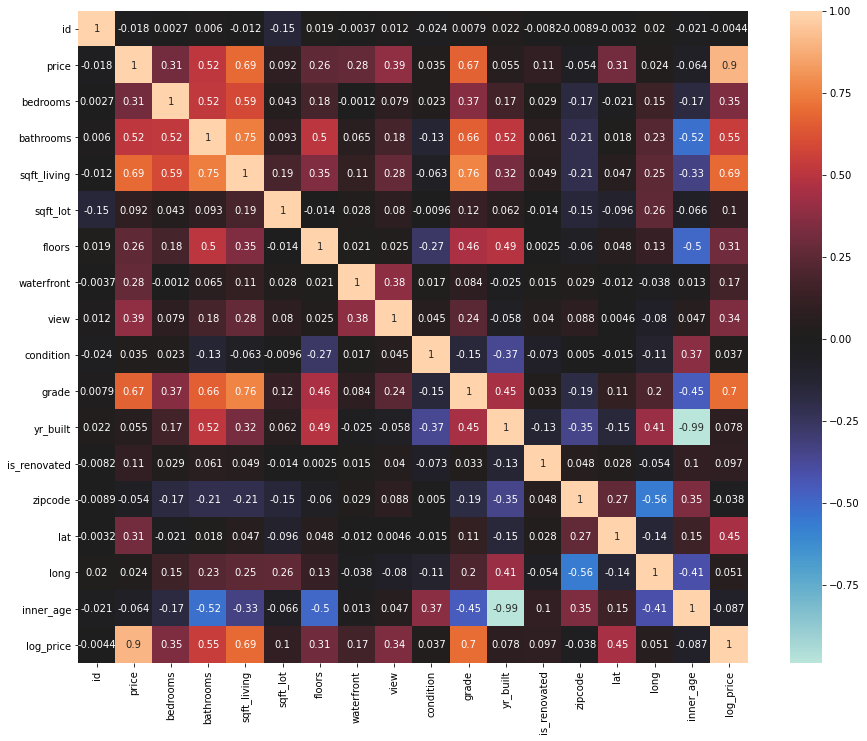

In [20]:
plt.figure(figsize=(15,12))
sns.heatmap(data=data.corr(), center=0, annot=True)

In [21]:
preprocessed_train=preprocessed.drop(data.sample(frac=0.3,random_state=1).index)
preprocessed_test =preprocessed.sample(frac=0.3,random_state=1)

In [22]:
X=preprocessed_train.drop(['price','log_price'],axis=1)
y=preprocessed_train['price']
y_=preprocessed_train['log_price']

In [23]:
X.columns

Index(['bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'is_renovated', 'zipcode', 'lat', 'long', 'inner_age',
       'beds_2', 'beds_3', 'beds_4', 'beds_5', 'beds_6', 'grade_fair',
       'grade_good', 'grade_excellent', 'age_new'],
      dtype='object')

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#predictors=preprocessed_train.columns[1:]
predictors=X.columns

outcome = 'log_price'
formula = outcome + '~' + '+'.join(predictors)

model = ols(formula=formula, data=X.join(y_)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     2282.
Date:                Fri, 03 Sep 2021   Prob (F-statistic):               0.00
Time:                        13:59:00   Log-Likelihood:                -763.66
No. Observations:               14912   AIC:                             1571.
Df Residuals:                   14890   BIC:                             1739.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          12.4456      4.350      2.861      0.004       3.920      20.972
bathrooms           0.0595      0.005     11.943      0.000       0.050       0.069
sqft_living         0.0002   4.66e-06     50.127      0.000       0.000       0.000
sqft_lot         4.386e-07   6.75e-08      6.499      0.000    3.06e-07    5.71e-07
floors              0.0515      0.005      9.901      0.000       0.041       0.062
waterfront          0.3517      0.028     12.571      0.000       0.297       0.406
view                0.0822      0.003     25.933      0.000       0.076       0.088
condition           0.0615      0.004     17.120      0.000       0.054       0.069
is_renovated        0.1571      0.016      9.771      0.000       0.126       0.189
zipcode            -0.0008   5.09e-05    -16.175      0.000      -0.001      -0.001
lat                 1.4208      0.016     86.750      0.000       1.389       1.453
long               -0.1000      0.020     -5.123      0.000      -0.138      -0.062
inner_age           0.0045      0.000     36.297      0.000       0.004       0.005
beds_2              0.0763      0.023      3.374      0.001       0.032       0.121
beds_3              0.0451      0.022      2.007      0.045       0.001       0.089
beds_4              0.0353      0.023      1.535      0.125      -0.010       0.080
beds_5             -0.0029      0.024     -0.120      0.905      -0.051       0.045
beds_6             -0.1007      0.030     -3.382      0.001      -0.159      -0.042
grade_fair          0.1965      0.008     24.388      0.000       0.181       0.212
grade_good          0.4063      0.010     42.639      0.000       0.388       0.425
grade_excellent     0.6580      0.015     45.118      0.000       0.629       0.687
age_new             0.1224      0.007     16.712      0.000       0.108       0.137
==============================================================================
Omnibus:                      258.273   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              516.295
Skew:                           0.050   Prob(JB):                    7.73e-113
Kurtosis:                       3.906   Cond. No.                     2.07e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
import scipy.stats as stats

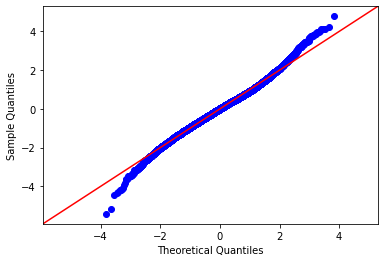

In [26]:
fig=sm.graphics.qqplot(model.resid,dist=stats.norm,line='45',fit=True)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

In [29]:
polyfeat=PolynomialFeatures(degree=2)
X_train_poly =polyfeat.fit_transform(X_train)
X_test_poly =polyfeat.fit_transform(X_test)

In [30]:
polyfit = linear_model.LinearRegression()
polyfit.fit(X_train_poly,y_train)
y_hat_train = polyfit.predict(X_train_poly)
train_residuals = y_hat_train - y_train

In [31]:
from sklearn.metrics import mean_squared_error
train_mse = mean_squared_error(y_train, y_hat_train)

In [32]:
train_mse

23086649596.940067

In [33]:
poly.fit(X_poly,y)
poly.score(X_poly,y)

NameError: name 'poly' is not defined

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

ols(y,X_poly).fit()

In [ ]:
predictors=preprocessed_train.columns[1:]
outcome = 'price'
formula = outcome + '~' + '+'.join(predictors)
formula

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#predictors=preprocessed_train.columns[1:]
predictors=trial

outcome = 'price'
formula = outcome + '~' + '+'.join(predictors)

model = ols(formula=formula, data=preprocessed_train).fit()

In [ ]:
model.summary()

In [ ]:
X_train=preprocessed_train.drop(['price'],axis=1)
y_train=preprocessed_train['price']

In [ ]:
X_train=X_train.drop(['sqft_lot'],axis=1)

In [ ]:
result = stepwise_selection(X_train, y_train, verbose=True)

In [ ]:
result

In [ ]:
initial_list=[] 
threshold_in=0.01
threshold_out = 0.05, 
verbose=True

In [ ]:
X=X_train

In [ ]:
y=y_train

In [ ]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
ModelX<-lm(log(price)~log(sqft_living)+log(bedrooms+0.5)+exp(bathrooms)+
           grade+waterfront+log(lat-min(Training$lat)+0.2)+log(zipcode-min(Training$zipcode)+4)+
           log(abs(long-min(Training$long))+0.01)+
           log(view+0.5)+condition+sqft_above+log(sqft_basement+0.001)+
           log(sqft_lot15)+log(2015-yr_renovated+1)+date+(bedrooms*bathrooms)+(view*log(condition))+sqft_basement+(log(grade)*exp(condition))+(bathrooms*log(sqft_living))+log(condition)+(view*bedrooms)+(zipcode*lat),data=Training)